In [3]:
import matplotlib
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rioxarray
from dask.distributed import Client

# Create a Dask local cluster
client = Client()

# Set the font to be serif, rather than sans
# plt.rcParams["font.family"] = "Noto Mono"

# Set the font size to be 12
plt.rcParams["font.size"] = 12


matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [4]:
template_path = "/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif"
files_path = "/mnt/sherlock/oak/prescribed_data/raw/vegetation"
path_to_mask = "/mnt/sherlock/oak/prescribed_data/geoms/california_geom/datacalifornia_geom.shp"

In [5]:
# Load template
template = (
    rioxarray.open_rasterio(
        "/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif"
    )
    .coarsen(dim={"x": 20, "y": 20}, boundary="trim")
    .max()
)

template_df = (
    template.to_dataframe(name="template")
    .reset_index()
    .drop(["spatial_ref", "band"], axis=1)
)

template_df = template_df[template_df.template == 1].reset_index(drop=True)
template_df["block_id"] = range(template_df.shape[0])

# Transform the template to a geodataframe
template_gdf = gpd.GeoDataFrame(
    template_df, geometry=gpd.points_from_xy(template_df.x, template_df.y)
).set_crs(epsg=3310)


/tmp/ipykernel_1306880/1731483987.py:8: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  template_gdf.iloc[fires].plot(
/tmp/ipykernel_1306880/1731483987.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.31613352 0.52158128 0.09066609 ... 0.7633399  0.03494665 0.90375573]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  template_gdf.loc[~template_gdf.index.isin(fires), "weight"] = np.random.uniform(
/tmp/ipykernel_1306880/1731483987.py:37: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  template_gdf.iloc[fires].plot(


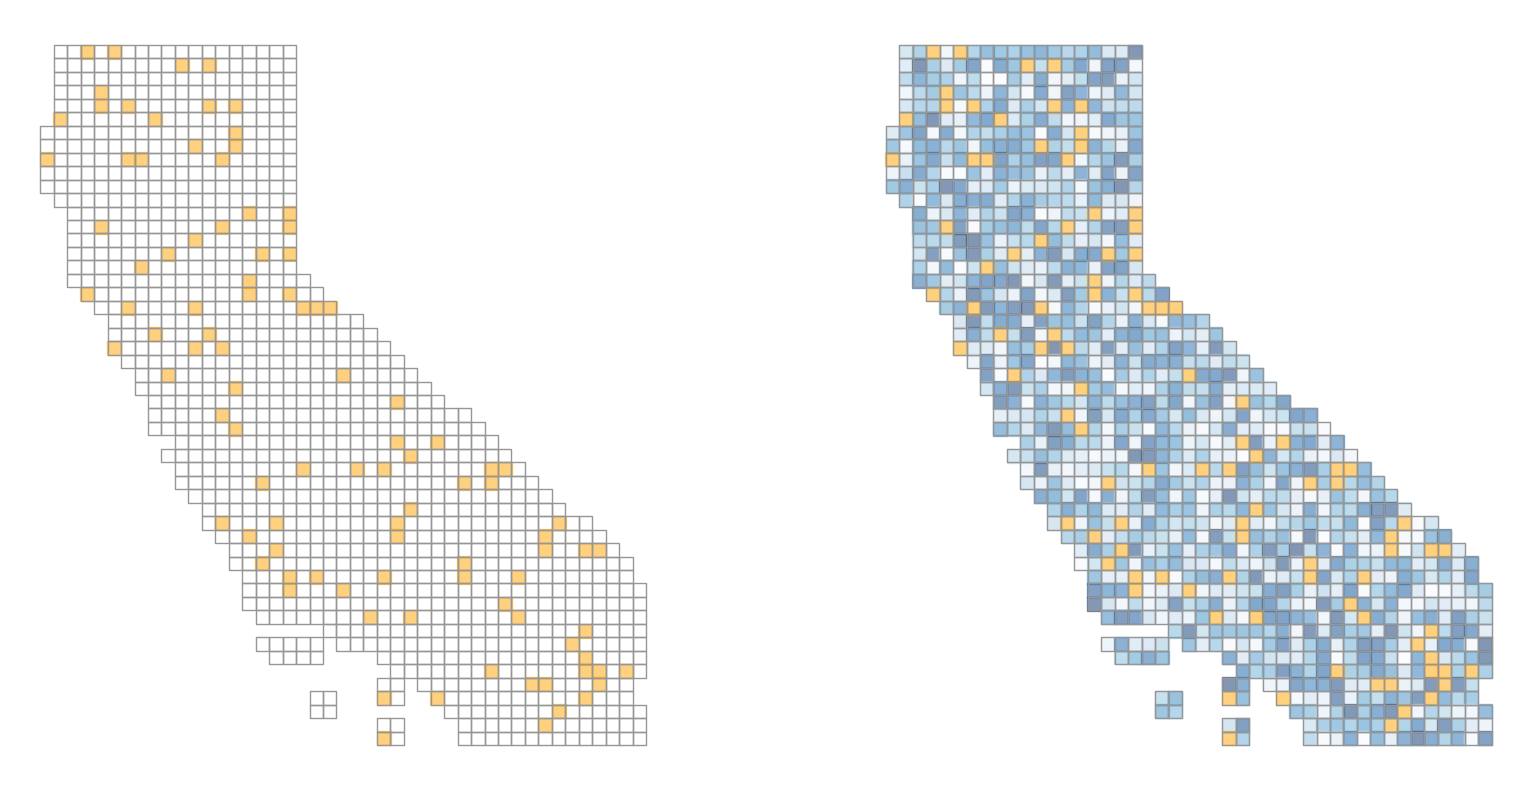

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
template_gdf.buffer(10000, cap_style=3).boundary.plot(
    ax=ax[0], color="#969696", linewidth=1
)

# Create fires randomly
fires = np.random.choice(template_gdf.index, 100, replace=False)
template_gdf.iloc[fires].plot(
    marker=",",
    markersize=100,
    ax=ax[0],
    column="block_id",
    color="orange",
    alpha=0.5,
)

# Remove axis from the plot
ax[0].axis("off")

template_gdf.buffer(10000, cap_style=3).boundary.plot(
    ax=ax[1], color="#969696", linewidth=1
)

# Create weights randomly
template_gdf["weight"] = 0
template_gdf.loc[~template_gdf.index.isin(fires), "weight"] = np.random.uniform(
    0, 1, template_gdf.shape[0] - 100
)
template_gdf[~template_gdf.index.isin(fires)].plot(
    marker=",",
    ax=ax[1],
    markersize=100,
    column="weight",
    cmap="Blues",
    alpha=0.5,
)
template_gdf.iloc[fires].plot(
    marker=",",
    markersize=100,
    ax=ax[1],
    column="block_id",
    color="orange",
    alpha=0.5,
)


# Remove axis from the plot
ax[1].axis("off")

# Save the plot
plt.savefig("../figs/synth_control.pdf", transparent=True)


### Plot synth control layers for plot

In [ ]:
import xarray as xr

plot_factor = 4

# Load template
template = (
    rioxarray.open_rasterio(
        "/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif"
    )
    .coarsen(dim={"x": 4, "y": 4}, boundary="trim")
    .mean()
)

# PRISM
prism = (
    (
        xr.open_mfdataset(
            "/mnt/sherlock/oak/prescribed_data/processed/prism_template/prism/*.nc"
        )
        .coarsen(dim={"lon": 4, "lat": 4}, boundary="trim")
        .mean()
    )
    .mean(dim="time")
    .compute()
)

vegetation = (
    xr.open_dataset(
        "/mnt/sherlock/oak/prescribed_data/processed/vegetation/frac_vegetation.nc"
    )
    .coarsen(dim={"lon": 4, "lat": 4}, boundary="trim")
    .mean()
    .mean(dim="year")
    .to_dataarray()
)

disturbances = (
    xr.open_mfdataset(
        "/mnt/sherlock/oak/prescribed_data/processed/disturbances/disturbances.nc"
    )
    .coarsen(dim={"lat": 4, "lon": 4}, boundary="trim")
    .mean()
    .to_dataarray()
)

elev = (
    xr.open_dataset(
        "/mnt/sherlock/oak/prescribed_data/processed/dem/dem_elevation.nc"
    )
    .coarsen(dim={"lat": 4, "lon": 4}, boundary="trim")
    .mean()
)


In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

elev.elevation.plot(cmap="terrain", ax=ax)

# Remove title
ax.set_title("")

# Remove axis
ax.axis("off")

# Remove colorbar
cbar = ax.collections[0].colorbar
cbar.remove()

# Save the figure as PNG
plt.savefig("elevation.png", bbox_inches="tight", dpi=300, transparent=True)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

vegetation.isel(variable=0, band=1).plot(ax=ax)

# Remove title
ax.set_title("")

# Remove axis
ax.axis("off")

# Remove colorbar
cbar = ax.collections[0].colorbar
cbar.remove()

# Save the figure as PNG
plt.savefig("vegetation.png", bbox_inches="tight", dpi=300, transparent=True)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
prism.tmin.plot(ax=ax)

# Remove axis
ax.axis("off")

# Remove colorbar
cbar = ax.collections[0].colorbar
cbar.remove()

# Save the figure as PNG
plt.savefig("prism_tmin.png", bbox_inches="tight", dpi=300, transparent=True)


In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
disturbances.isel(variable=0, time=4).plot(ax=ax)

# Remove axis
ax.axis("off")

# Remove title
ax.set_title("")

# Remove colorbar
cbar = ax.collections[0].colorbar
cbar.remove()

# Save the figure as PNG
plt.savefig("disturbances.png", bbox_inches="tight", dpi=300, transparent=True)
